In [4]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [5]:
# Configurable parameters for dynamic use
CONFIG = {
    'file_path': 'datasets\dt11.xls',  # Path to your CSV
    'date_column': None,  # Optional for stats; set for consistency
    'value_column': None,  # Sales/revenue column; auto-detect
    'date_format': '%d/%m/%Y',  # Optional
    'product_keywords': ['product', 'item', 'item_name'],  # For auto-detecting product column
    'category_keywords': ['category', 'brand', 'sub-category'],  # For brand/category
    'quantity_keywords': ['quantity', 'qty', 'units', 'order quantity', 'shipped', 'sold', 'count'],# For Quantity
    'top_n': 10,  # Number of top items to plot
    'plot_title_prefix': 'Sales Statistics'
}

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Fau\AppData\Local\Temp\ipykernel_2232\1016245129.py:3: SyntaxWarning: invalid escape sequence '\d'
  'file_path': 'datasets\dt11.xls',  # Path to your CSV


In [6]:
def detect_column(df, keywords):
    """
    Generic auto-detection for columns based on keywords (case-insensitive).
    Prioritizes exact matches and numeric where applicable.
    """
    for col in df.columns:
        if any(keyword.lower() in col.lower() for keyword in keywords):
            # Prefer numeric for quantity/sales
            if pd.api.types.is_numeric_dtype(df[col]):
                return col
            return col  # First match otherwise
    return None

In [7]:
def load_data(file_path, value_col=None, date_format=None):
    """
    Load data from CSV, XLSX, XLS, JSON, or JSONL with full auto-detection.
    Handles encoding, delimiters, Excel engines, and JSON structures.
    """
    import os
    import pandas as pd

    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return None, None

    file_ext = os.path.splitext(file_path)[1].lower()
    df = None

    # ========================================
    # 1. EXCEL FILES (.xlsx, .xls)
    # ========================================
    if file_ext in ['.xlsx', '.xls']:
        try:
            df = pd.read_excel(file_path, engine=None)  # auto: openpyxl or xlrd
            print(f"Loaded Excel file: {file_path}")
        except Exception as e:
            print(f"Failed to read Excel file: {e}")
            return None, None

    # ========================================
    # 2. TEXT / DELIMITED FILES (.csv, .txt, .tsv)
    # ========================================
    elif file_ext in ['.csv', '.txt', '.tsv']:
        encodings = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']
        for enc in encodings:
            try:
                df = pd.read_csv(file_path, encoding=enc, sep=None, engine='python')
                print(f"Loaded text file with encoding: {enc}")
                break
            except UnicodeDecodeError:
                continue
            except Exception as e:
                print(f"Failed with {enc}: {e}")
                continue
        else:
            print("Error: Could not read text file with any common encoding.")
            return None, None

    # ========================================
    # 3. JSON FILES (.json, .jsonl, .ndjson)
    # ========================================
    elif file_ext in ['.json', '.jsonl', '.ndjson']:
        try:
            if file_ext == '.json':
                # Standard JSON: list of objects or object of arrays
                df = pd.read_json(file_path, orient='records', lines=False)
                print(f"Loaded standard JSON file: {file_path}")
            else:
                # Newline-delimited JSON (JSONL)
                df = pd.read_json(file_path, orient='records', lines=True)
                print(f"Loaded JSONL/NDJSON file: {file_path}")
        except Exception as e:
            print(f"Failed to read JSON file: {e}")
            return None, None

    # ========================================
    # 4. UNSUPPORTED FORMAT
    # ========================================
    else:
        print(f"Unsupported file type: {file_ext}")
        return None, None

    # ========================================
    # 5. POST-LOAD PROCESSING (Same for all formats)
    # ========================================
    print(f"Loaded data shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")

    # Auto-detect sales/value column
    if value_col is None:
        value_col = detect_column(df, [
            'sales', 'revenue', 'amount', 'value', 'price', 'total',
            'grand total', 'order total', 'net sales'
        ])
        if value_col is None:
            raise ValueError("Could not auto-detect sales/revenue column. Try setting 'value_column' in CONFIG.")
        print(f"Auto-detected sales column: {value_col}")

    # Auto-detect product, category, quantity
    product_col = detect_column(df, CONFIG['product_keywords'])
    category_col = detect_column(df, CONFIG['category_keywords'])

    quantity_col = None
    for col in df.columns:
        lower_col = col.lower()
        if any(k.lower() in lower_col for k in CONFIG['quantity_keywords']) and pd.api.types.is_numeric_dtype(df[col]):
            quantity_col = col
            break

    # Clean sales column
    df[value_col] = pd.to_numeric(df[value_col], errors='coerce')
    df = df.dropna(subset=[value_col])

    if quantity_col:
        df[quantity_col] = pd.to_numeric(df[quantity_col], errors='coerce')
        df = df.dropna(subset=[quantity_col])

    detected = {
        'sales_col': value_col,
        'product_col': product_col,
        'category_col': category_col,
        'quantity_col': quantity_col
    }
    print(f"Detected columns: {detected}")
    return df, detected

In [8]:
def compute_statistics(df, detected):
    """
    Compute key statistics.
    """
    sales_col = detected['sales_col']
    product_col = detected['product_col']
    category_col = detected['category_col']
    quantity_col = detected['quantity_col']

    stats = {}

    # Total revenue
    stats['total_revenue'] = df[sales_col].sum()

    # Best selling item (by revenue)
    if product_col:
        item_sales = df.groupby(product_col)[sales_col].sum().nlargest(1)
        stats['best_selling_item'] = item_sales.index[0]
        stats['best_item_revenue'] = item_sales.iloc[0]
    else:
        stats['best_selling_item'] = None

    # Best selling brand/category (by revenue)
    if category_col:
        category_sales = df.groupby(category_col)[sales_col].sum().nlargest(1)
        stats['best_selling_brand'] = category_sales.index[0]
        stats['best_brand_revenue'] = category_sales.iloc[0]
    else:
        stats['best_selling_brand'] = None

    # Most stock sold (item by quantity)
    if quantity_col and product_col:
        item_qty = df.groupby(product_col)[quantity_col].sum().nlargest(1)
        stats['most_stock_item'] = item_qty.index[0]
        stats['most_stock_qty'] = item_qty.iloc[0]
    else:
        stats['most_stock_item'] = None

    # Biggest revenue from sales: top category or item (already covered)
    # Additional: top N for plots

    return stats

In [9]:
def plot_statistics(df, detected, stats, top_n=10):
    """
    Safe plotting with quarterly analysis.
    """
    plt.style.use('default')

    # === EXTRACT ===
    sales_col = detected.get('sales_col')
    product_col = detected.get('product_col')
    category_col = detected.get('category_col')
    quantity_col = detected.get('quantity_col')
    date_col = detected.get('date_col')  #

    if not sales_col:
        st.error("No sales column detected.")
        return

    # === 1. TOP & WORST PERFORMERS ===
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))

    # Top/Bottom Sales (Product)
    if product_col and sales_col in df.columns:
        sales_by_product = df.groupby(product_col)[sales_col].sum()
        top_sales = sales_by_product.nlargest(top_n)
        bottom_sales = sales_by_product.nsmallest(top_n)

        top_sales.plot(kind='bar', ax=axes[0,0], color='skyblue')
        axes[0,0].set_title(f'Top {top_n} Items (Revenue)')
        axes[0,0].tick_params(axis='x', rotation=45, labelsize=8)

        bottom_sales.plot(kind='bar', ax=axes[1,0], color='salmon')
        axes[1,0].set_title(f'Bottom {top_n} Items (Revenue)')
        axes[1,0].tick_params(axis='x', rotation=45, labelsize=8)

    # Top/Bottom Categories
    if category_col and sales_col in df.columns:
        sales_by_cat = df.groupby(category_col)[sales_col].sum()
        top_cat = sales_by_cat.nlargest(top_n)
        bottom_cat = sales_by_cat.nsmallest(top_n)

        top_cat.plot(kind='bar', ax=axes[0,1], color='lightcoral')
        axes[0,1].set_title(f'Top {top_n} Categories')
        axes[0,1].tick_params(axis='x', rotation=45, labelsize=8)

        bottom_cat.plot(kind='bar', ax=axes[1,1], color='lightgray')
        axes[1,1].set_title(f'Bottom {top_n} Categories')
        axes[1,1].tick_params(axis='x', rotation=45, labelsize=8)

    # Top/Bottom Quantity
    if quantity_col and product_col:
        qty_by_product = df.groupby(product_col)[quantity_col].sum()
        top_qty = qty_by_product.nlargest(top_n)
        bottom_qty = qty_by_product.nsmallest(top_n)

        top_qty.plot(kind='bar', ax=axes[0,2], color='lightgreen')
        axes[0,2].set_title(f'Top {top_n} by Units')
        axes[0,2].tick_params(axis='x', rotation=45, labelsize=8)

        bottom_qty.plot(kind='bar', ax=axes[1,2], color='wheat')
        axes[1,2].set_title(f'Bottom {top_n} by Units')
        axes[1,2].tick_params(axis='x', rotation=45, labelsize=8)

    plt.suptitle("Performance Overview: Top vs Bottom", fontsize=16)
    plt.tight_layout()
    plt.show()

    # === 2. QUARTERLY ANALYSIS (ONLY IF DATE EXISTS) ===
    if date_col and date_col in df.columns:
        df_q = df.copy()
        df_q['Quarter'] = df_q[date_col].dt.to_period('Q').astype(str)
        quarterly = df_q.groupby('Quarter')[sales_col].sum()
        growth = quarterly.pct_change() * 100

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        quarterly.plot(kind='bar', ax=ax1, color='teal')
        ax1.set_title('Revenue by Quarter')
        ax1.set_ylabel('Revenue ($)')
        for i, v in enumerate(quarterly):
            ax1.text(i, v, f"${v:,.0f}", ha='center', va='bottom')

        colors = ['green' if x > 0 else 'red' for x in growth.dropna()]
        growth.dropna().plot(kind='bar', ax=ax2, color=colors)
        ax2.set_title('QoQ Growth %')
        ax2.set_ylabel('Growth %')
        for i, v in enumerate(growth.dropna()):
            ax2.text(i, v + (3 if v >= 0 else -6), f"{v:+.1f}%", ha='center')

        plt.suptitle("Quarterly Business Performance", fontsize=16)
        plt.tight_layout()
        plt.show()

        # Top product per quarter
        top_per_q = (
            df_q.groupby(['Quarter', product_col])[sales_col]
            .sum()
            .groupby('Quarter')
            .nlargest(1)
            .reset_index()
            .drop(columns='level_1')
        )
        st.write("**Top Product Each Quarter**")
        st.dataframe(top_per_q, use_container_width=True)

    # === 3. TOTAL REVENUE ===
    plt.figure(figsize=(8, 6))
    plt.text(0.5, 0.5, f'Total Revenue: ${stats["total_revenue"]:,.2f}',
             ha='center', va='center', fontsize=22, fontweight='bold',
             transform=plt.gca().transAxes)
    plt.title("Sales Overview", fontsize=16)
    plt.axis('off')
    plt.show()

In [10]:
def print_statistics(stats):
    """
    Nicely print the statistics.
    """
    print("\n" + "="*50)
    print("SALES STATISTICS SUMMARY")
    print("="*50)
    print(f"Total Revenue: ${stats['total_revenue']:,.2f}")

    if stats['best_selling_item']:
        print(f"Best Selling Item: {stats['best_selling_item']} (${stats['best_item_revenue']:,.2f})")

    if stats['best_selling_brand']:
        print(f"Best Selling Brand/Category: {stats['best_selling_brand']} (${stats['best_brand_revenue']:,.2f})")

    if stats['most_stock_item']:
        print(f"Most Stock Sold Item: {stats['most_stock_item']} (Qty: {stats['most_stock_qty']:.0f})")

    if not any([stats['best_selling_item'], stats['best_selling_brand'], stats['most_stock_item']]):
        print("Note: Could not detect product/brand/quantity columns. Stats limited to total revenue.")
    print("="*50)

In [11]:
def main(config):
    """
    Main function to compute and display statistics.
    """
    # Load data
    df, detected = load_data(
        config['file_path'],
        config['value_column'],
        config['date_format']
    )
    if df is None:
        return

    # Compute stats 
    stats = compute_statistics(df, detected)

    # Print stats
    print_statistics(stats)

    # Plot
    plot_statistics(df, detected, stats, config['top_n'])

    # Export plots
    plt.savefig("sales_report.png")

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
Loaded Excel file: datasets\dt11.xls
Loaded data shape: (9994, 21)
Columns: ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit']
Auto-detected sales column: Sales
Detected columns: {'sales_col': 'Sales', 'product_col': 'Product ID', 'category_col': 'Category', 'quantity_col': 'Quantity'}

SALES STATISTICS SUMMARY
Total Revenue: $2,297,200.86
Best Selling Item: TEC-CO-10004722 ($61,599.82)
Best Selling Brand/Category: Technology ($836,154.03)
Most Stock Sold Item: TEC-AC-10003832 (Qty: 75)


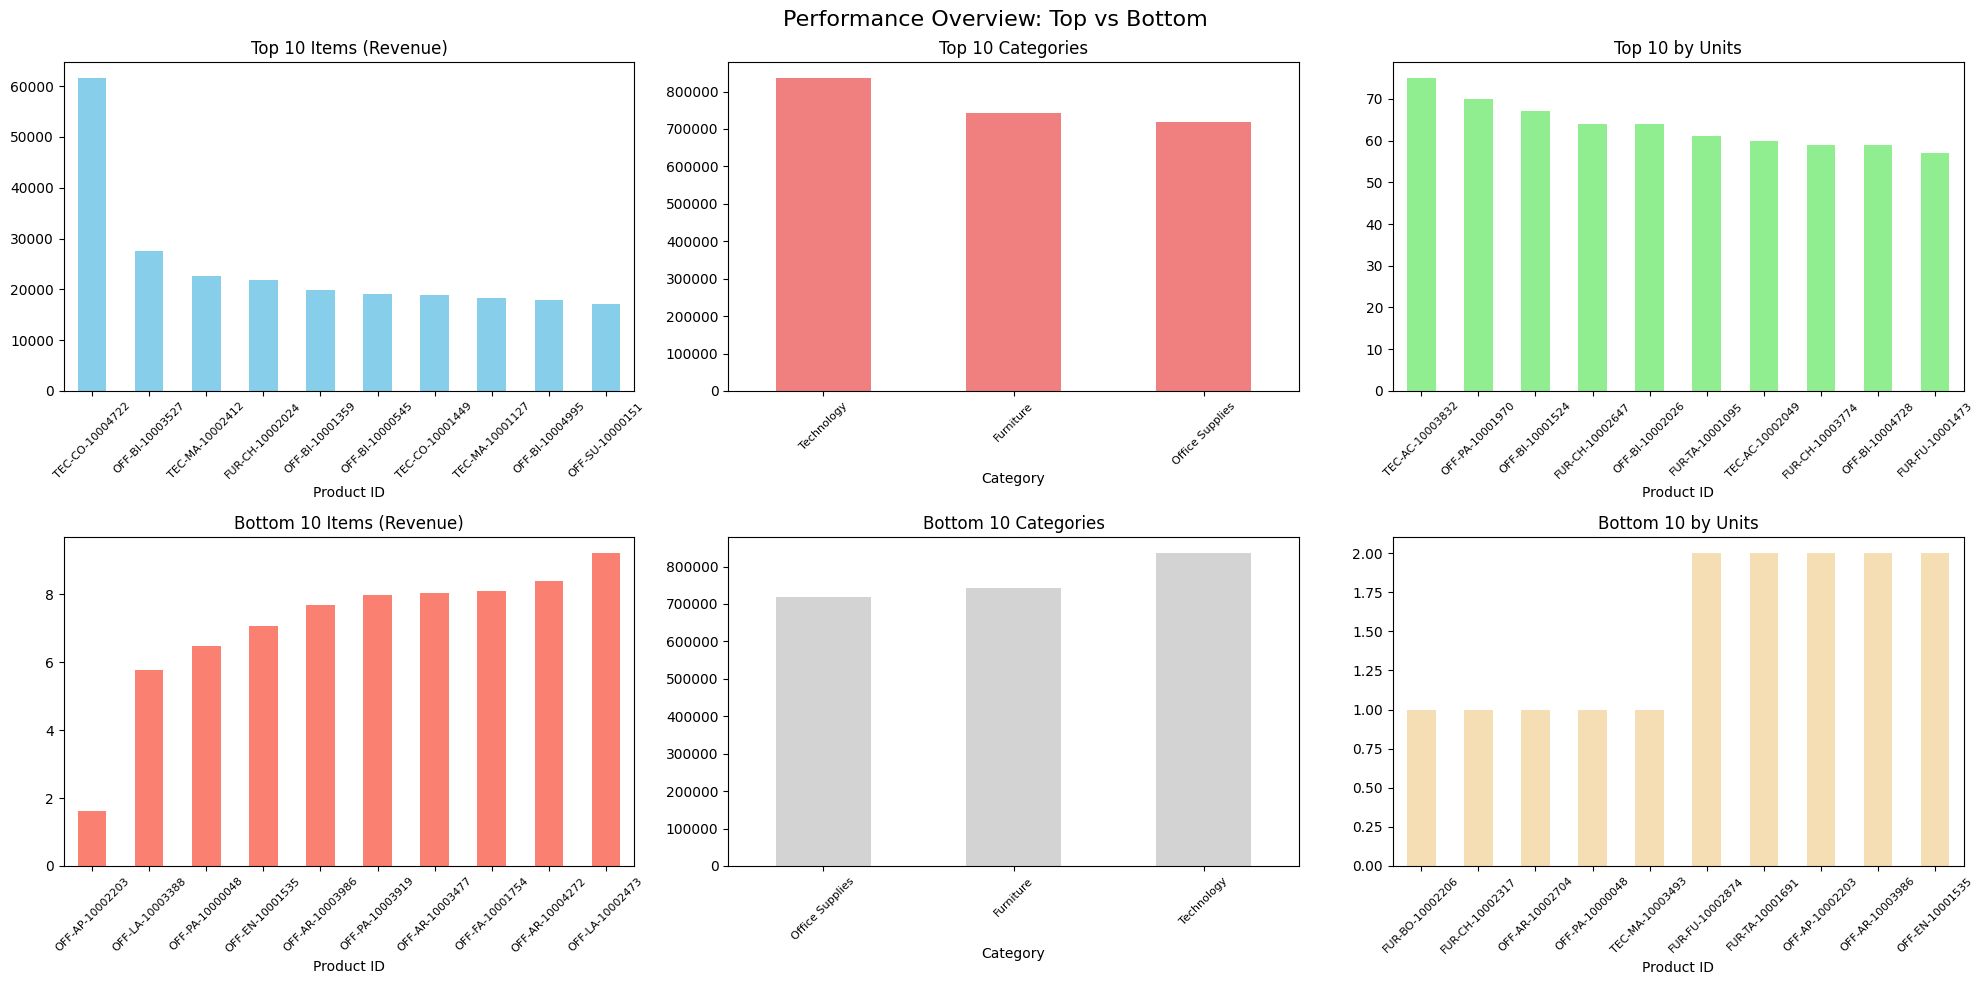

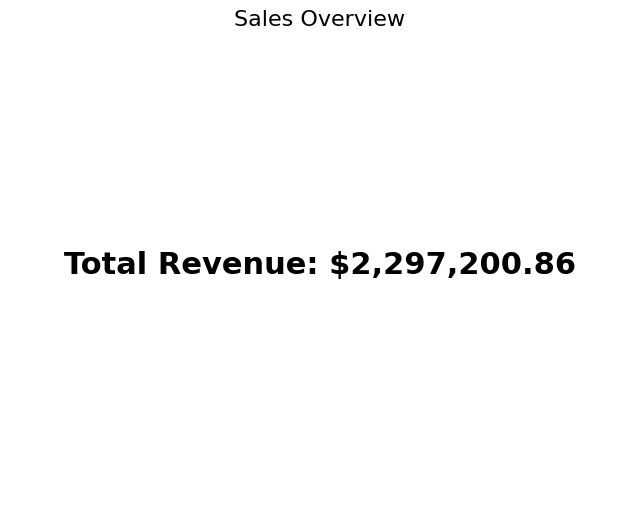

<Figure size 640x480 with 0 Axes>

In [12]:
if __name__ == "__main__":
    main(CONFIG)